# transmon_cont_env

In [8]:
# copy file to modify here

In [1]:
import gym
import gym_transmon_cont
from gym_utils import *

# Two-qubit examples
## sqrtZX - quspin

In [6]:
# physical setting
sim_name = 'quspin'
num_transmon = 2
num_level = 3
sim_frame_rotation = False
drive = np.array([100*MHz, 14*MHz])
detune = np.array([115*MHz, 0])
anharm = np.array([-319.7*MHz, -320.2*MHz])
coupling = np.array([1.87*MHz])
ctrl_noise = 0

# objective
num_seg = 100
duration = 224 #in ns
duration_gauss = int(73/duration*num_seg)
duration_const = int(115/duration*num_seg)
duration_drag = int(36/duration*num_seg)
dt = duration/num_seg*nanosec
target_gate = 'sqrtZX'

# state
rl_state = 'ket'
pca_order = (4,2)

# reward
reward_type = 'average'
reward_scheme = 'local-fidelity-difference'
fid_threshold = 0.999
worstfid_method = 'SLSQP-ket-7'

# action
action_size = 4
sub_action_scale = None
end_amp_window = None
evolve_method = 'exact'

kw = initialize_transmon_env(sim_name,num_transmon, num_level, sim_frame_rotation,
                             drive, detune, anharm, coupling, ctrl_noise,
                             num_seg, dt, target_gate,
                             rl_state, pca_order,
                             reward_type, reward_scheme, fid_threshold, worstfid_method,
                             action_size, sub_action_scale, end_amp_window, evolve_method)
# env = ContinuousTransmonEnv(**kw)
env = gym.make('transmon-cont-v7',**kw)

---Initiating Transmon Environment with Continuous Action---
-   Noiseless control


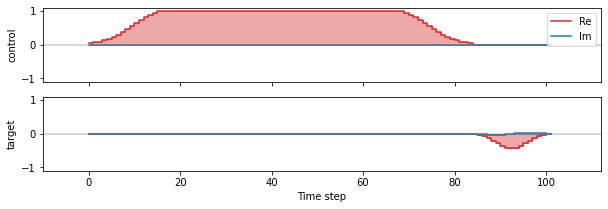

-----------------------------------------------
Average fidelity:    0.9941521407860391
Worst case fidelity: 0.9899311848415232


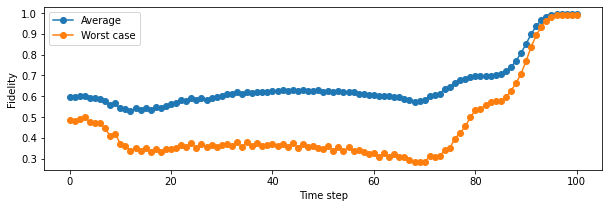

Max worst case fidelity: 0.990893315112999 at step 100


0.09351152570522347

In [7]:
# cross-resonance
sig = 14.5/(duration/num_seg)
amp = 1
phase = 0

x_gauss = np.linspace(0,duration_gauss,duration_gauss+1)
x_const = np.ones(duration_const)
cr1_pulse = cr1(x_gauss,x_const,amp,sig,phase)

# drag
sig = 7.3/(duration/num_seg)
amp = -0.43
beta = 0.4

x_drag = np.linspace(0,duration_drag,duration_drag+1)
drag_pulse = drag(x_drag,amp,beta,sig)

# combine
cr1_total_pulse = np.hstack([cr1_pulse,np.zeros_like(cr1_pulse)])
drag_total_pulse = np.hstack([np.zeros_like(drag_pulse),drag_pulse])
total_pulse = np.vstack([cr1_total_pulse,drag_total_pulse])

channel_labels = ['control','target']
plot_pulse(total_pulse,channel_labels)
plt.show()

# run environment
env.step_params['reward_type'] = 'average'
env.reset()
avg_fids = []
states = []
for action in total_pulse:
    state,reward,done,_ = env.step(action)
    avg_fids.append(env.fid)
    states.append(state)
avg_fids = np.array(avg_fids)
states = np.array(states)

env.step_params['reward_type'] = 'worst'
env.reset()
worst_fids = []
for action in total_pulse:
    state,reward,done,_ = env.step(action)
    worst_fids.append(env.fid)
worst_fids = np.array(worst_fids)

print('-----------------------------------------------')
print(f'Average fidelity:    {avg_fids[-1]}')
print(f'Worst case fidelity: {worst_fids[-1]}')

plt.figure(figsize=(10,3))
plt.plot(avg_fids,'o-',label='Average')
plt.plot(worst_fids,'o-',label='Worst case')
plt.xlabel('Time step')
plt.ylabel('Fidelity')
plt.legend()
plt.show()
print(f'Max worst case fidelity: {worst_fids.max()} at step {worst_fids.argmax()+1}')
abs(total_pulse[1:]-total_pulse[:-1]).max()

## SWAP - TransmonDuffingSimulator

In [3]:
# physical setting
sim_name = 'TransmonDuffingSimulator'
num_transmon = 2
num_level = 3
sim_frame_rotation = False

dt = 4*nanosec
anharm   = 2*np.pi * np.array([-319.7,-320.2])*MHz
drive    = 2*np.pi * np.array([30,300,30,300])*MHz
detune   = 2*np.pi * np.array([115,0])*MHz
coupling = 2*np.pi * np.array([1.87])*MHz
ctrl_noise = 0

# objective
num_seg = 160
target_gate = 'SWAP'

# state
rl_state = 'ket'
pca_order = (4,2)

# reward
reward_type = 'average'
reward_scheme = 'local-fidelity-difference'
fid_threshold = 0.999
worstfid_method = 'SLSQP-ket-7'

# action
action_size = 4
sub_action_scale = None
end_amp_window = None
evolve_method = 'exact'

kw = initialize_transmon_env(sim_name,num_transmon, num_level, sim_frame_rotation,
                             drive, detune, anharm, coupling, ctrl_noise,
                             num_seg, dt, target_gate,
                             rl_state, pca_order,
                             reward_type, reward_scheme, fid_threshold, worstfid_method,
                             action_size, sub_action_scale, end_amp_window, evolve_method)
env = gym.make('transmon-cont-v7',**kw)
# env = ContinuousTransmonEnv(**kw)

---Initiating Transmon Environment with Continuous Action---
-   Noiseless control


-----------------------------------------------
Final fidelities
  Average: 0.9885
  Worst  : 0.9778
Max worst-case fidelity: 0.9778 at step 160


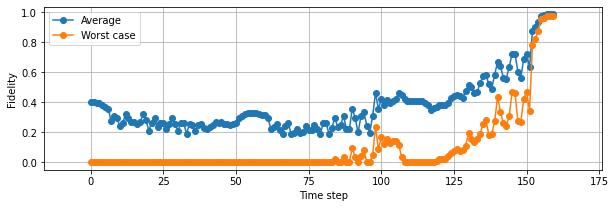

Max amp difference: 0.44


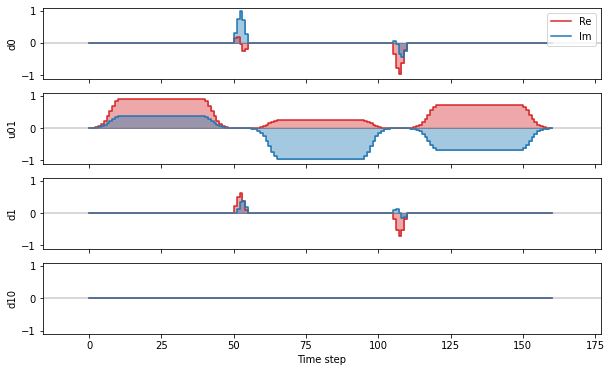

In [4]:
# Saved optimized angles
x_X90I = np.array([ 1.        ,  0.25705079, -0.46631134, -1.33888415])
x_IX90 = np.array([ 0.71479103,  0.24319973, -0.41055427, -0.11303429])
x_CNOT = np.array([ 0.45272866,  1.        ,  0.15123441, -0.15832501])
x_SWAP = np.array([ 0.40192683, 1.60814476 ,  0.50891225, -1.31562956, 
                   -2.81163055, -3.13722026, -0.74656652])

channel_labels = ['d0','u01','d1','d10']

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

cnot_pulse_1 = np.zeros([len(GS_pulse),8])
cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x_SWAP[0])

hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x_SWAP[1])
hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[2])

cnot_pulse_2 = np.zeros([len(GS_pulse),8])
cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x_SWAP[3])

hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x_SWAP[4])
hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[5])

cnot_pulse_3 = np.zeros([len(GS_pulse),8])
cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x_SWAP[6])

total_pulse = np.vstack([cnot_pulse_1,hh_pulse_1,
                         cnot_pulse_2,hh_pulse_2,cnot_pulse_3])

max_diff = abs(total_pulse[1:,:]-total_pulse[:-1,:]).max()

# run environment
env.step_params['reward_type'] = 'average'
env.reset()
avg_fids = []
states = []
for action in total_pulse:
    state,reward,done,_ = env.step(action)
    avg_fids.append(env.fid)
    states.append(state)
avg_fids = np.array(avg_fids)
states = np.array(states)

env.step_params['reward_type'] = 'worst'
env.reset()
worst_fids = []
for action in total_pulse:
    state,reward,done,_ = env.step(action)
    worst_fids.append(env.fid)
worst_fids = np.array(worst_fids)

print('-----------------------------------------------')
print('Final fidelities')
print(f'  Average: {avg_fids[-1]:.4f}')
print(f'  Worst  : {worst_fids[-1]:.4f}')
print(f'Max worst-case fidelity: {worst_fids.max():.4f} at step {worst_fids.argmax()+1}')

plt.figure(figsize=(10,3))
plt.plot(avg_fids,'o-',label='Average')
plt.plot(worst_fids,'o-',label='Worst case')
plt.xlim([-int(0.1*len(total_pulse)),len(total_pulse)+int(0.1*len(total_pulse))])
plt.xlabel('Time step')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.show()

print(f'Max amp difference: {max_diff:.2f}')
plot_pulse(total_pulse,channel_labels)

In [28]:
dFavg = avg_fids[1:]-avg_fids[:-1]
Favg = (avg_fids[1:]+avg_fids[:-1])/2

0.2218487496163564

In [24]:
env.avg_fid+dFavg.sum()

0.9885823077527688

In [25]:
NLI(avg_fids[-1])

1.9382059050891387

In [43]:
dNLI = dFavg/(1-Favg)/np.log(10)
# dNLI = dFavg/(1-avg_fids[:-1])/np.log(10)
NLI(env.avg_fid)+dNLI.sum()

1.8555099449465462

In [44]:
dNLI

array([-1.69305281e-04, -9.52777832e-04, -2.48852522e-03, -7.86667357e-03,
       -7.85925357e-03, -9.13594763e-03, -5.30975316e-02,  1.91252104e-02,
       -5.30229162e-03, -3.34422551e-02,  1.27255088e-02,  3.38557481e-02,
       -1.26934172e-02, -1.86572118e-02,  6.36151957e-04, -7.25551457e-03,
        5.41101703e-03,  3.49849644e-02, -2.36924284e-02, -4.29224279e-02,
        3.13535359e-02,  1.90782932e-02, -3.63264549e-02,  1.50473646e-02,
        5.10942652e-04, -2.40983681e-02,  2.17646735e-02,  2.27112861e-02,
       -2.53439668e-02, -2.40771428e-02,  2.79531505e-02, -6.67249033e-04,
       -3.89494635e-02,  3.71523790e-02, -4.17328936e-03, -2.36180813e-02,
        2.40643766e-02,  3.14508195e-03, -1.46900802e-02, -4.67639014e-03,
        9.48744120e-03,  7.76531901e-03,  8.28318065e-03, -9.70135058e-04,
        1.07611044e-03, -7.54750137e-03,  2.78544976e-03, -3.98426821e-03,
        2.52267786e-03,  5.04687295e-03,  1.89313539e-02,  6.36558763e-03,
        1.05894550e-02,  